# MONAI : Tutorial : modules
## 2D image transformation demo

参照URL:
- https://github.com/Project-MONAI/tutorials/blob/main/modules/transforms_demo_2d.ipynb
- https://www.classcat.com/medical_ai/2021/10/12/monai-0-7-tutorials-modules-transforms-demo-2d/

## 0. 準備

In [1]:
# パッケージのインストール
#!python -c "import monai" || pip install -q "monai-weekly[pillow,tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib

In [2]:
# パッケージのインポート
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.transforms import Affine, Rand2DElastic

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.12.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/akira/venv/monai/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.26.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installi

In [3]:
# データフォルダ
root_dir = './data'

In [4]:
# データダウロード
resource = (
    "https://warwick.ac.uk/fac/sci/dcs/research/tia/"
    + "glascontest/download/warwick_qu_dataset_released_2016_07_08.zip"
)
md5 = None

compressed_file = os.path.join(root_dir, 'warwick_qu_dataset_released_2016_07_08.zip')
data_dir = os.path.join(root_dir, 'Warwick QU Dataset (Released 2016_07_08)')
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## 1. データ可視化

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
img_name = os.path.join(data_dir, 'train_22.bmp')
seg_name = os.path.join(data_dir, 'train_22_anno.bmp')
im = np.array(Image.open(img_name))
seg = np.array(Image.open(seg_name))

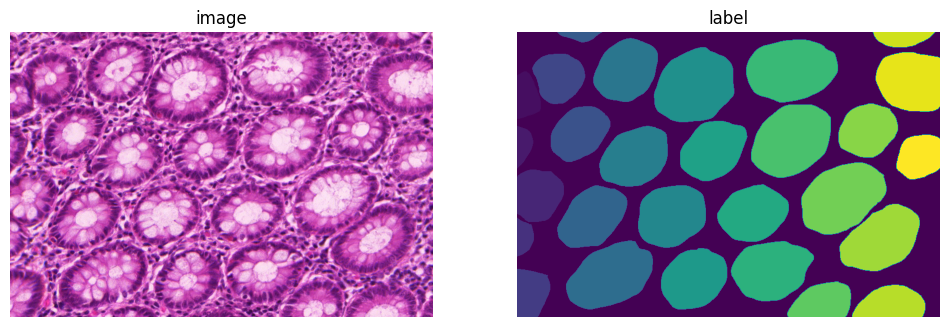

(522, 775, 3) (522, 775)


In [7]:
plt.figure('check', figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(im)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(seg)
plt.axis('off')
plt.show()
print(im.shape, seg.shape)

## 2. 画像変換
### 2.1 アフィン変換

In [8]:
# MONAI transforms always take channel-first data: [channel x H x W]
im_data = np.moveaxis(im, -1, 0) # make them channel first
seg_data = np.expand_dims(seg, 0) # make a channel for the segmentation

# create an Affine transform
affine = Affine(
    rotate_params=np.pi / 4,
    scale_params=(1.2, 1.2),
    translate_params=(200, 40),
    padding_mode='zeros',
    device=device,
)

# conver both image and segmentation using different inter polation mode
new_img, _ = affine(im_data, (300, 400), mode='bilinear')
new_seg, _ = affine(seg_data, (300, 400), mode='bilinear')
print(new_img.shape, new_seg.shape)

torch.Size([3, 300, 400]) torch.Size([1, 300, 400])


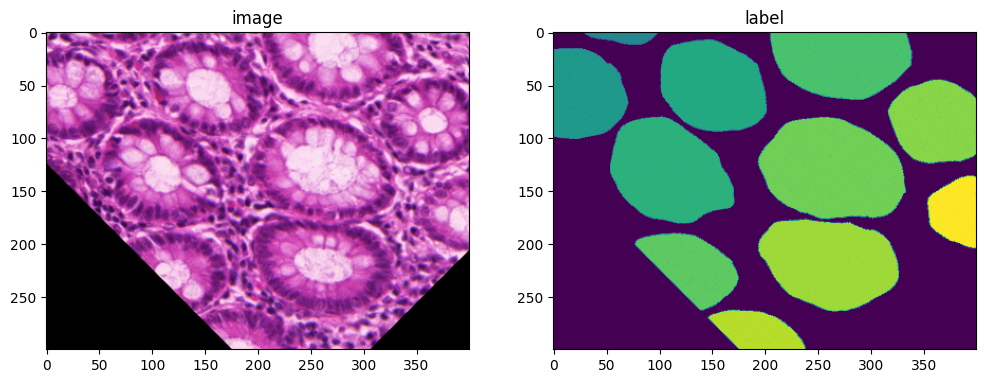

In [9]:
plt.figure('check', figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(new_seg[0].astype(int))
plt.show()

## 2.2 弾性変形

In [10]:
# create an elastic deformation transform
deform = Rand2DElastic(
    prob=1.0,
    spacing=(30, 30),
    magnitude_range=(5, 6),
    rotate_range=(np.pi / 4),
    scale_range=(0.2, 0.2),
    translate_range=(100, 100),
    padding_mode='zeros',
    device=device,
)

In [11]:
# transform both imae and segmentation using different interpolation mode
deform.set_random_state(seed=123)
new_img = deform(im_data, (224, 224), mode='bilinear')
deform.set_random_state(seed=123)
new_seg = deform(seg_data, (224, 224), mode='nearest')
print(new_img.shape, new_seg.shape)

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


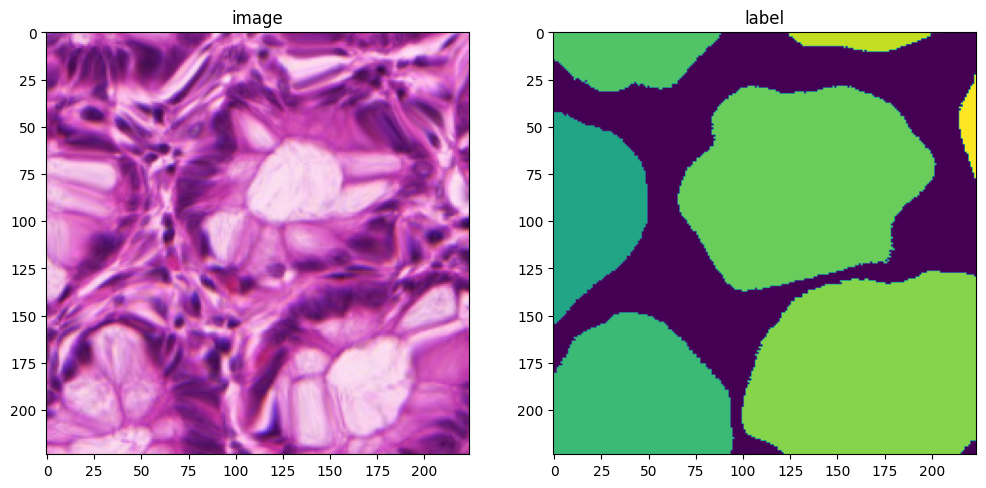

In [12]:
plt.figure('check', figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(np.moveaxis(new_img.astype(int), 0, -1))

plt.subplot(1, 2, 2)
plt.title('label')
plt.imshow(new_seg[0].astype(int))
plt.show()